## Importing and cleaning train 

In [25]:
import pandas as pd
train= pd.read_csv('./nlp/tweets.csv', sep='^([^,]+),', engine='python', error_bad_lines=False, encoding='utf-8', index_col=[0])

In [26]:
train.head()

,polarity,statutnull
NaN,0,"- Awww, c'est un bummer. Tu devrais avoir davi..."
NaN,0,Est contrarié qu'il ne puisse pas mettre à jou...
NaN,0,J'ai plongé plusieurs fois pour la balle. A ré...
NaN,0,Tout mon corps a des démangeaisons et comme si...
NaN,0,"Non, il ne se comporte pas du tout. je suis en..."


In [27]:
train = train.reset_index(drop=True)

In [28]:
train.columns

Index(['polarity', 'statutnull'], dtype='object')

In [30]:
# pour test, à supprimer
train = train.sample(n=100000)

(-0.5, 799.5, 499.5, -0.5)

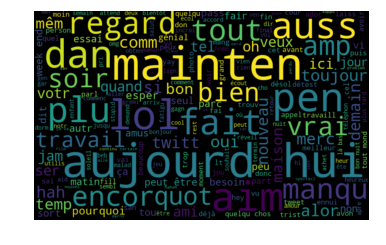

In [88]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
all_text= ' '.join([x for text in train.tweet for x in text])
wordcloud = WordCloud(width=800, height=500, random_state=21,max_font_size=110).generate(all_text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')

In [29]:
def clean_up(s):
    import re
    s= re.sub(r'http\S+|(www\.[^\s]+)|(@\S+)',' ',s)
    s=re.sub('[\d]',' ',s)
    s= re.sub('[^\w\s]',' ',s)
    s= re.sub('\s\s+',' ',s)
    s=s.lower().strip()
    return s
def tokenize(s):
    from nltk.tokenize import word_tokenize
    return word_tokenize(s)
def stem(tweet):
    from nltk.stem.snowball import FrenchStemmer
    stemmer = FrenchStemmer()
    return list(map(lambda s: stemmer.stem(s), tweet))
def remove_stopwords(l):
    from nltk.corpus import stopwords
    stop_words = stopwords.words('french')
    stop_words.append('rt')
    return [x for x in l if x not in stop_words]
train.statutnull=train.statutnull.astype(str)

In [31]:
train.statutnull = train.statutnull.apply(lambda s: clean_up(s))

In [32]:
train.statutnull = train.statutnull.apply(lambda s: tokenize(s))

In [33]:
train.statutnull = train.statutnull.apply(lambda s: stem(s))

In [34]:
train.statutnull = train.statutnull.apply(lambda s: remove_stopwords(s))

In [35]:
train.rename(columns={'statutnull':'tweet'},inplace=True)

In [37]:
train.shape

(100000, 2)

In [38]:
train = train.dropna()

In [39]:
#train['tweet']=' '.join(train['tweet'])
train.head()

,polarity,tweet
1049404,4,"[ête, probabl, tres, intéress, dan, vi, réel, ..."
833421,4,"[amus, salon, dont, manqu, entendr]"
644799,0,"[font, attendr, jusqu, seul, entre, ici, jusqu..."
1362499,4,"[merc, vendred, suiv]"
76067,0,"[non, avant, pull, jumeau, imag, don, assembla..."


In [40]:
index_zero = train[(train['polarity'] != '0') & (train['polarity']!= '4')].index
train.drop(index_zero, inplace=True)

In [115]:
train['polarity'] = train['polarity'].str.replace("0","negatif").str.replace("4","positif")

## Building model 

In [42]:
all_words = []
import nltk
NUM_FEATURES = 5000
for index, value in train.tweet.iteritems():
    if value not in all_words:
        all_words += value

top_features = [x[0] for x in nltk.FreqDist(all_words).most_common(NUM_FEATURES)]

In [141]:
df=pd.DataFrame.from_dict(nltk.FreqDist(all_words),orient='index')
df.sort_values(by=0, ascending=False).reset_index().head(10)

,index,0
0,a,11059
1,dan,7065
2,tout,6370
3,plus,5951
4,bon,5949
5,aim,5644
6,si,5341
7,mainten,5251
8,bien,5198
9,être,5189


In [43]:
top_features[:10]

['a', 'dan', 'tout', 'plus', 'bon', 'aim', 'si', 'mainten', 'bien', 'être']

In [44]:
def build_features(words):
    features = {}
    for w in top_features:
        features[w] = (w in words)
    return features

In [54]:
featuresets = []

for index, row in train.iterrows():
    featuresets.append((build_features(row['tweet']), row['polarity']))

In [55]:
featuresets[:5]

[({'a': False,
   'dan': True,
   'tout': False,
   'plus': False,
   'bon': False,
   'aim': False,
   'si': False,
   'mainten': False,
   'bien': False,
   'être': False,
   'fair': False,
   'jour': False,
   'fait': False,
   'hui': False,
   'aujourd': False,
   'tel': False,
   'pens': False,
   'vrai': False,
   'ça': False,
   'lol': False,
   'peux': False,
   'quelqu': False,
   'merc': False,
   'regard': False,
   'vais': True,
   'aller': False,
   'auss': False,
   'votr': False,
   'manqu': False,
   'travail': False,
   'temp': False,
   'comm': False,
   'avoir': False,
   'chos': False,
   'veux': False,
   'just': True,
   'maison': False,
   'encor': False,
   'peut': False,
   'soir': False,
   'heur': False,
   'cet': False,
   'journ': False,
   'ser': False,
   'oh': False,
   'oui': False,
   'pass': False,
   'va': False,
   'nuit': False,
   'alor': False,
   'toujour': False,
   'esper': False,
   'amp': False,
   'voir': False,
   'nouveau': False,
   'tou

In [56]:
from nltk import NaiveBayesClassifier
from sklearn.model_selection import train_test_split
train_set, test = train_test_split(featuresets, test_size=0.2)
classifier = NaiveBayesClassifier.train(train_set)

In [74]:
classifier.show_most_informative_features(n=25)

Most Informative Features
               mercinull = True                4 : 0      =     43.8 : 1.0
                   déced = True                0 : 4      =     24.3 : 1.0
                    ughh = True                0 : 4      =     18.3 : 1.0
                   trist = True                0 : 4      =     17.6 : 1.0
                 éviscer = True                0 : 4      =     15.0 : 1.0
                     sux = True                0 : 4      =     14.2 : 1.0
                    booo = True                0 : 4      =     13.8 : 1.0
                   honor = True                4 : 0      =     13.0 : 1.0
                  injust = True                0 : 4      =     13.0 : 1.0
                tristess = True                0 : 4      =     13.0 : 1.0
                     fml = True                0 : 4      =     13.0 : 1.0
                   fievr = True                0 : 4      =     12.8 : 1.0
                  bummed = True                0 : 4      =     12.7 : 1.0

AttributeError: 'NoneType' object has no attribute 'plot'

In [59]:
import nltk
nltk.classify.accuracy(classifier, test)

0.741998399679936

In [108]:
def clean_up(s):
    import re
    s= re.sub(r'http\S+|(www\.[^\s]+)|(@\S+)',' ',s)
    s=re.sub('[\d]',' ',s)
    s= re.sub('[^\w\s]',' ',s)
    s= re.sub('\s\s+',' ',s)
    s=s.lower().strip()
    from nltk.tokenize import word_tokenize
    s=word_tokenize(s)
    from nltk.stem.snowball import FrenchStemmer
    stemmer = FrenchStemmer()
    s = list(map(lambda x: stemmer.stem(x), s))
    from nltk.corpus import stopwords
    stop_words = stopwords.words('french')
    stop_words.append('rt')
    return [x for x in s if x not in stop_words]

In [116]:
phrase='Je déteste la grève !'
phrase_clean=clean_up(phrase)
classifier.classify(dict([token,True] for token in phrase_clean))

'0'